In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [1]:
# load cifar10 dataset and split data into training(70%) and testing(30%) subsets.
def load_dataset():
    ds_all, ds_info = tfds.load(
        name='cifar10',
        split='train[:10%]+test[:20%]',
        shuffle_files=True,
        with_info=True,
        as_supervised=True,
        read_config=tfds.ReadConfig(shuffle_seed=100)
    )

    len_all = len(ds_all)
    train_size = int(0.7 * len_all)
    
    # split whole dataset 
    ds_train = ds_all.take(train_size)
    ds_test = ds_all.skip(train_size)
    
    # check sizes
    print('Train samples:\t\t%d (%.1f%%) ' % (len(ds_train), 100*len(ds_train)/len_all))
    print('Test samples:\t\t%d (%.1f%%) ' % (len(ds_test), 100*len(ds_test)/len_all))
    print('All samples:\t\t%d (%.1f%%) ' % (len(ds_all), 100*len(ds_all)/len_all))

    return ds_train, ds_test, ds_info

In [3]:
# resize images to 64x64
imgsize = 32 # define image size
def resize_image(image, label):
    im = tf.image.resize_with_pad(image, target_height=imgsize, target_width=imgsize)
    im = tf.cast(im, tf.uint8)
    return im, label

In [4]:
# plot one sample image of each class of the dataset
def plot_dataset(ds, info):
    nclasses = info.features['label'].num_classes
    class_names = info.features['label'].names
    samples = dict([[i, [class_names[i]]] for i in range(nclasses)])
    ds_np = tfds.as_numpy(ds)
    
    for image, label in ds_np:
        if image.ndim == 4:
            for i in range(image.shape[0]):
                if len(samples[label[i]]) == 1:
                    samples[label[i]].append(image[i,...])
        elif image.ndim == 3:
            if len(samples[label]) == 1:
                samples[label].append(image)

    fig, axs = plt.subplots(int(np.ceil(nclasses/4)), 4, figsize=(10,10))
    for r in range(axs.shape[0]):
        for c in range(axs.shape[1]):
            try:
                iclass = r*axs.shape[1]+c
                axs[r,c].imshow(samples[iclass][1])
                axs[r,c].set_title("%s (%d)" % (samples[iclass][0], iclass), size=8)
            except KeyError:
                pass
            finally:
                axs[r,c].axis('off')

    plt.show()
            


In [5]:
# plot a batch of the dataset
def plot_batch(ds, ibatch):
    batch = ds.skip(ibatch)
    batch = batch.take(1)
    images, labels = next(iter(tfds.as_numpy(batch)))
    nsamples = images.shape[0]

    fig, axs = plt.subplots(int(np.ceil(nsamples/4)), 4, figsize=(nsamples//8, nsamples//2))
    for r in range(axs.shape[0]):
        for c in range(axs.shape[1]):
            try:
                isample = r*axs.shape[1]+c
                axs[r,c].imshow(images[isample,...])
                axs[r,c].set_title("class: %d" % (labels[isample]), size=8)
            except IndexError:
                pass
            finally:
                axs[r,c].axis('off')

    plt.show()

In [6]:
# Here is a standard dataset pipeline
# first, load train and test datasets
ds_train, ds_test, ds_info = load_dataset()

# for the train dataset, resize image, cache data, shuffle and put them in batches. then prefetch it for performance imporovement.
ds_train = ds_train.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples, seed=100)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# for the test dataset, we don't need shuffling.
ds_test = ds_test.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Train samples:		4900 (70.0%) 
Test samples:		2100 (30.0%) 
All samples:		7000 (100.0%) 


Plotting all classes...


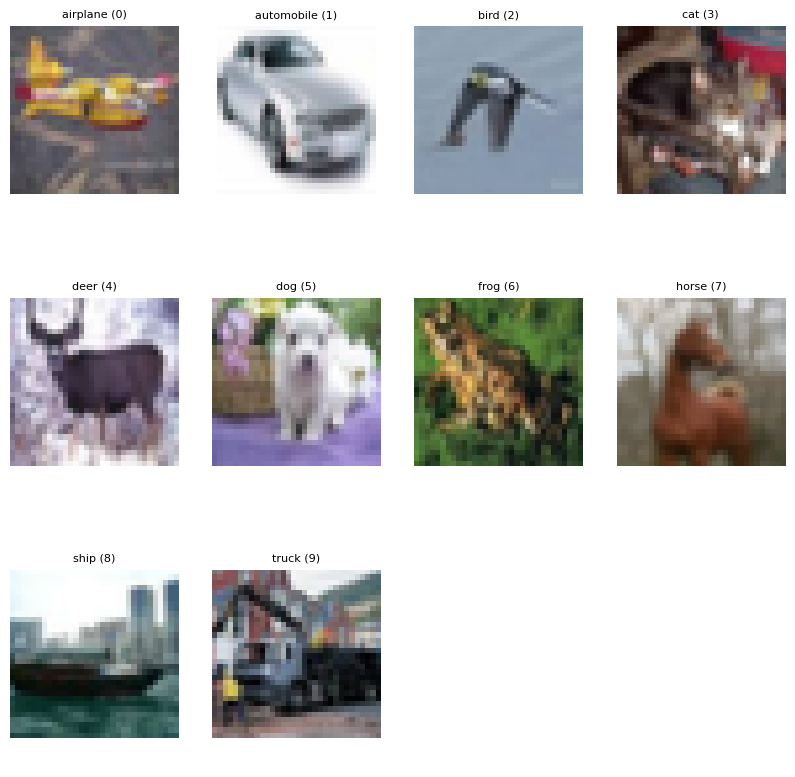

Plotting batch 0...


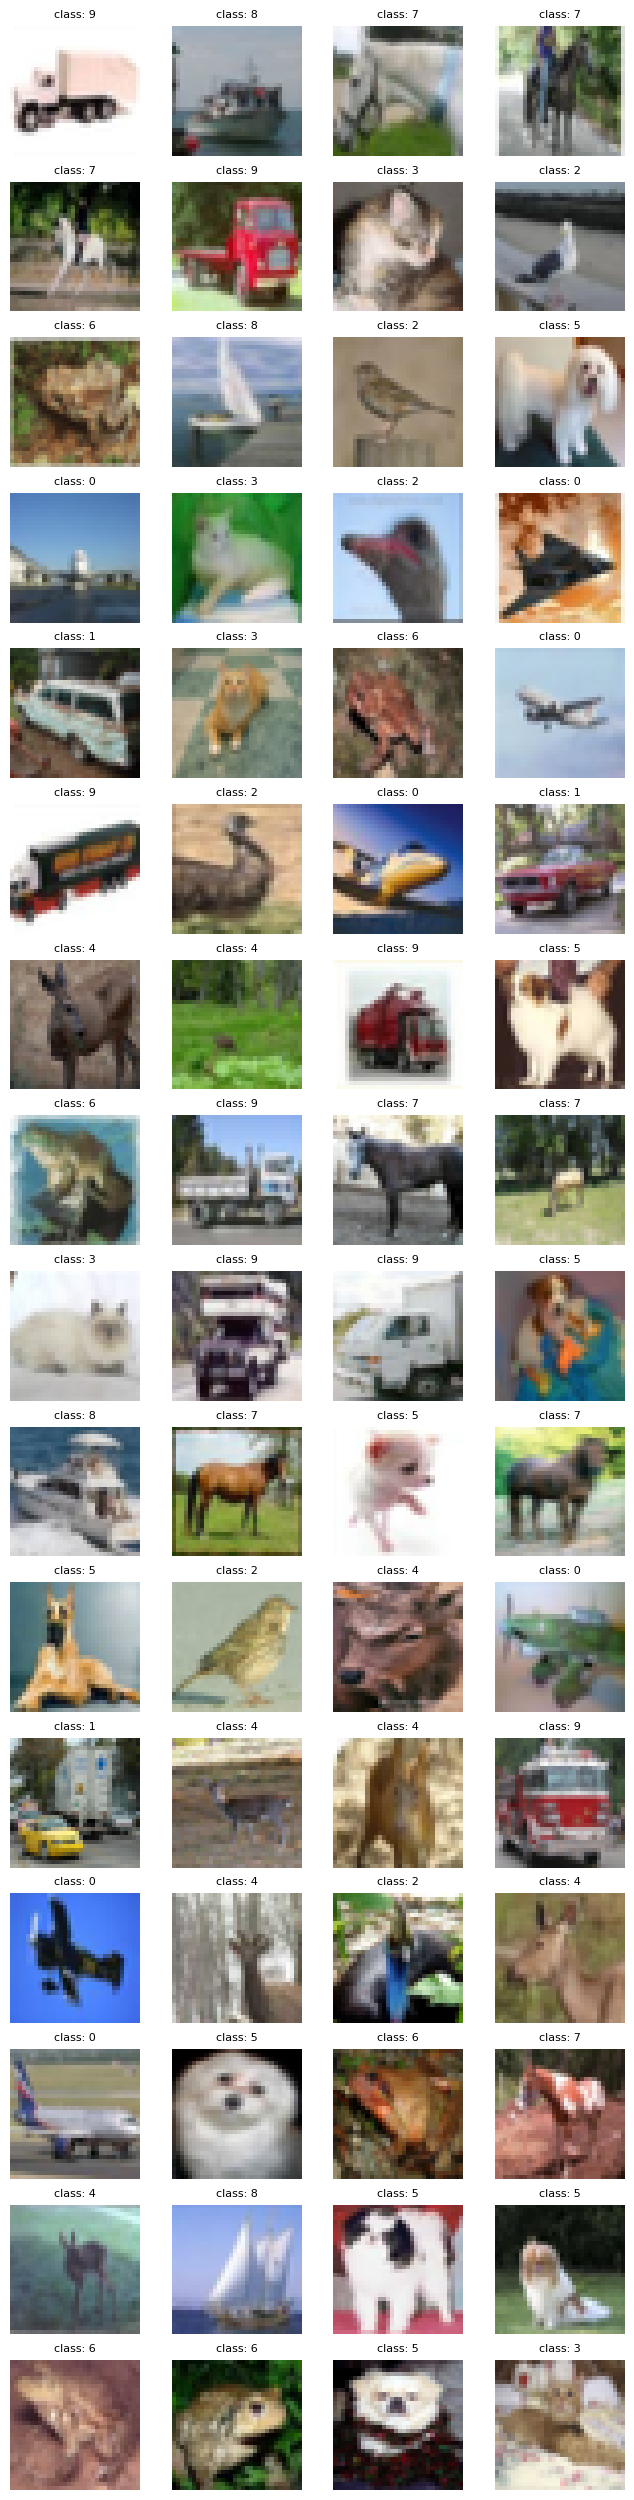

In [7]:
# plot a sample of each class
print('Plotting all classes...')
plot_dataset(ds_train, ds_info)
# fig = tfds.show_examples(ds_train, ds_info) # this tfds function plots samples of the dataset too.

# plot the samples inside batch 0
print('Plotting batch 0...')
plot_batch(ds_train, 0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 model (Functional)          (None, 2, 2, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 32, 32, 3)]       0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 32, 32, 64)        1792      |
|                                                          

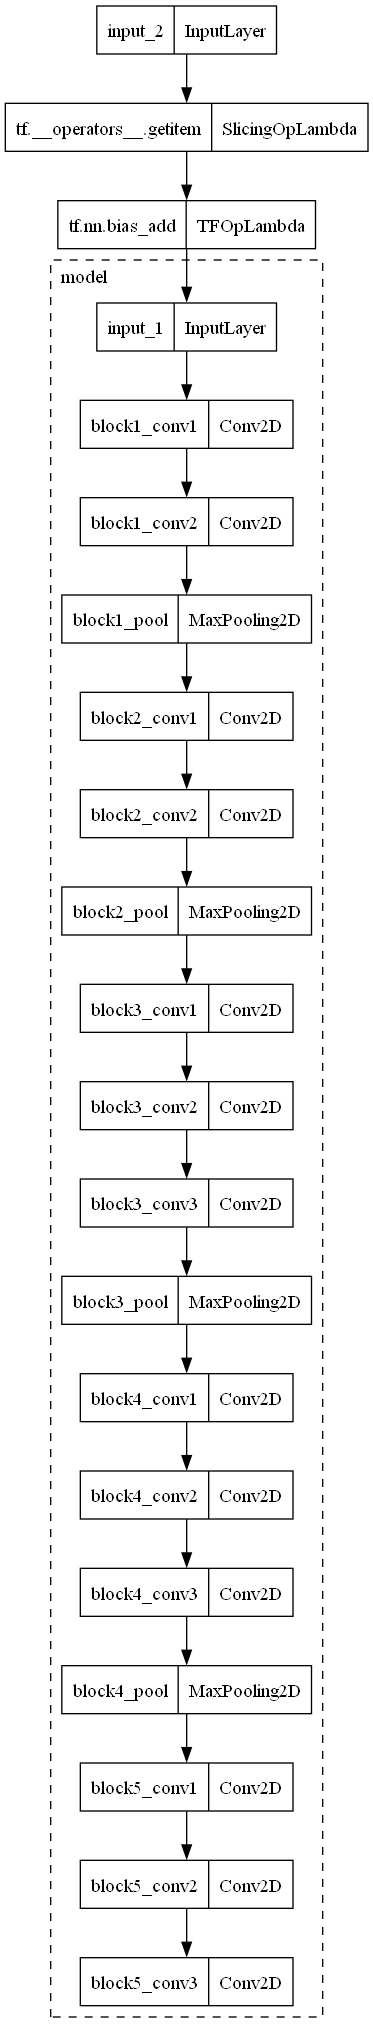

In [8]:
# creating our feature extractor network using VGG-16.
from tensorflow.keras.applications import vgg16
org_vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(imgsize, imgsize, 3))

input = tf.keras.layers.Input(shape=(imgsize, imgsize, 3), dtype = tf.uint8)
preprocess = vgg16.preprocess_input(input) # images need to be preprocessed to be usable by vgg16.
vgg_modified = tf.keras.Model(inputs=org_vgg_model.input, outputs=org_vgg_model.get_layer('block5_conv3').output) # we don't want the whole vgg16. we want the network only upto the block5 before pooling.
output = vgg_modified(preprocess) 
feat_extractor_model = tf.keras.Model(inputs=input, outputs=output)
feat_extractor_model.summary(expand_nested=True)
tf.keras.utils.plot_model(feat_extractor_model, expand_nested=True)

In [9]:
# extract the features on the training and testing datasets
train_features = feat_extractor_model.predict(ds_train)
test_features = feat_extractor_model.predict(ds_test)

33/33 [==============================] - 1s 25ms/step


In [10]:
# putting the labels in the dataset batches into one array
train_labels = [l.flatten() for _, l in tfds.as_numpy(ds_train)]
train_labels = np.concatenate(train_labels)

test_labels = [l.flatten() for _, l in tfds.as_numpy(ds_test)]
test_labels = np.concatenate(test_labels)

In [11]:
# creating a random forrest classifier. inputs: extracted features (by vgg), outputs: class labels
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 200, random_state = 100, n_jobs=10)
rf_model.fit(train_features.reshape(train_features.shape[0],-1), train_labels) # we have to flatten the features to feed to the random forrest

RandomForestClassifier(n_estimators=200, n_jobs=10, random_state=100)

Accuracy = 9.00%


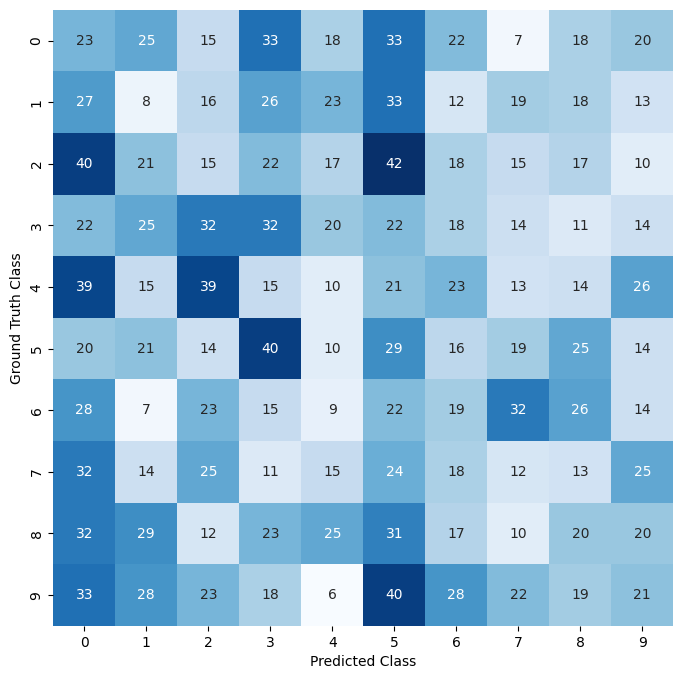

In [12]:
# testing the accuaracy of the fitted random forrest classifier and plotting a confusion matrix.
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

rf_pred = rf_model.predict(test_features[...,:512].reshape(test_features.shape[0],-1))
print ("Accuracy = %.2f%%" % (100*accuracy_score(test_labels, rf_pred)))
cm = confusion_matrix(test_labels, rf_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth Class')
plt.show()